In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import test_proportions_2indep, confint_proportions_2indep
import numpy as np
from bootstrap_stat import bootstrap_stat as bp
from scipy.stats import median_test, ttest_ind

In [4]:
df = pd.read_csv('credit_cards.csv')
df.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Question 1: whether there are differences between median credit limits of dafaulted and not defaulted customers

In is clearly seen from qq plots and histograms that data isn't distributed normally. I used non-papametric median test
H0: medians of two distributions are simmilar
H1: medians are diffirent


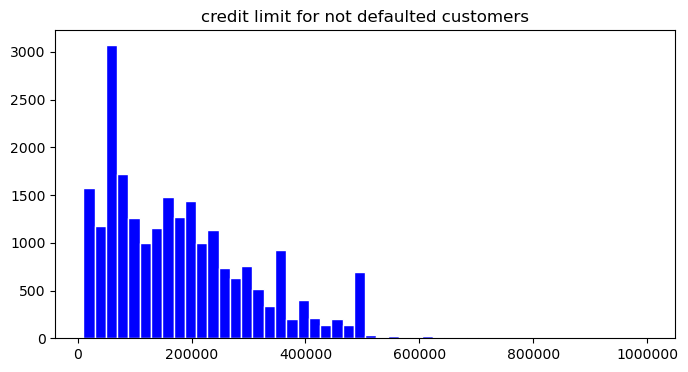

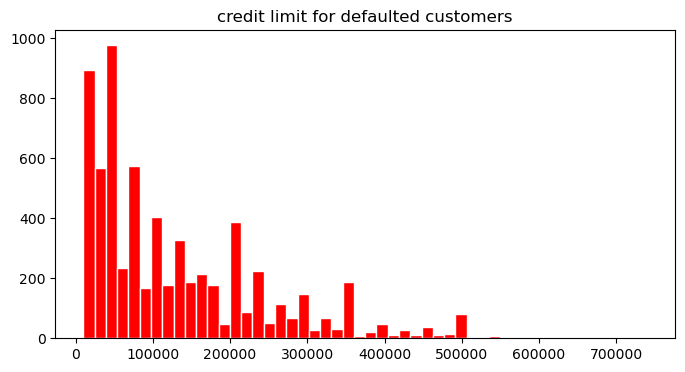

In [5]:
default = df[df['default'] == 1]['LIMIT_BAL']
no_default = df[df['default'] == 0]['LIMIT_BAL']


plt.figure(figsize = (8, 4))
ax = plt.gca()
plt.hist(no_default, bins = 50, label = 'no default', color = 'blue', edgecolor = 'white')
plt.title('credit limit for not defaulted customers')
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()

plt.figure(figsize = (8, 4))
plt.hist(default, bins = 50, label = 'default', color = 'red', edgecolor = 'white')
plt.title('credit limit for defaulted customers')
plt.show()

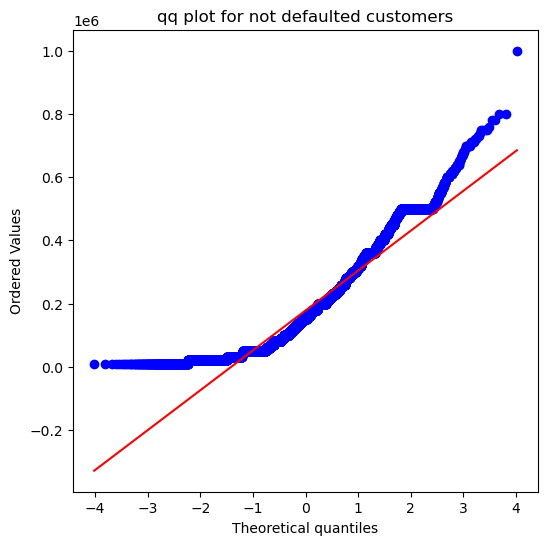

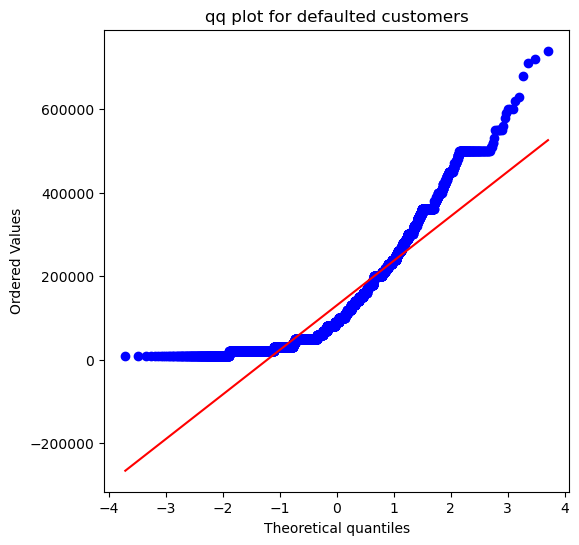

In [6]:
plt.figure(figsize = (6, 6))
stats.probplot(no_default, dist = "norm", plot = plt)
plt.title('qq plot for not defaulted customers')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(default, dist = 'norm', plot = plt)
plt.title('qq plot for defaulted customers')
plt.show()

In [10]:
stat, p_value, med, table = median_test(default, no_default)
print(f"statistic: {stat}, p-val: {p_value}, median: {med}")

statistic: 683.1982729785927, p-val: 1.3471418011496702e-150, median: 140000.0


In [11]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

default = np.array(default)
no_default = np.array(no_default)

np.random.seed(0)

default_median_scores = list(map(np.median, get_bootstrap_samples(default, 5000)))
no_default_median_scores = list(map(np.median, get_bootstrap_samples(no_default, 5000)))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(default_median_scores, no_default_median_scores)))
print("95% confidence interval for the difference between median credit limits:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between median credit limits: [60000. 70000.]


Based on the results of median test, there is significalt difference between credit limit distributions for defaulted and not defaulted customers ($ p < 0.001 $). Difference in medians with 95% confidence lies in interval [60000., 70000.]

### Question 2: whether gender composition of two groups differ

In this case I used z-test for two independent samples

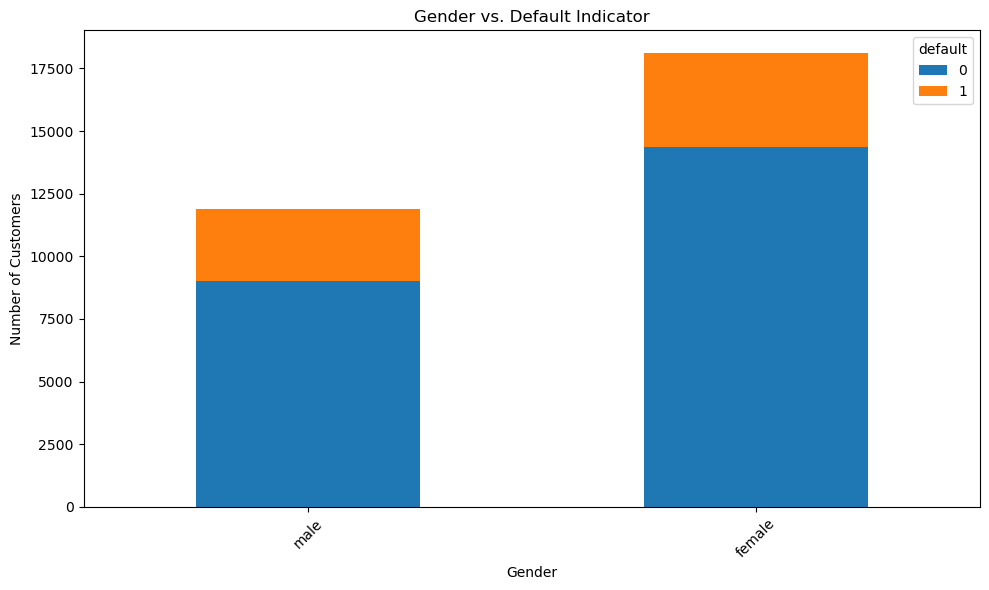

In [12]:
df_filtered = df[df['GENDER'].isin([1, 2])]
ct = pd.crosstab(df_filtered['GENDER'], df['default'])
ct = ct.rename(index={1: 'male', 2: 'female'})

ax = ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Gender vs. Default Indicator')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
default_m = df[(df['default'] == 1) & (df['GENDER'] == 1)].shape[0]
no_default_m = df[(df['default'] == 0) & (df['GENDER'] == 1)].shape[0]

total_default = df[df['default'] == 1].shape[0]
total_no_default = df[df['default'] == 0].shape[0]

print("Z test:", test_proportions_2indep(default_m, total_default, no_default_m, total_no_default, alternative = 'two-sided',
                                          method = 'wald',  return_results=False))
print("Wald's interval:", confint_proportions_2indep(default_m, total_default, no_default_m, total_no_default, method = 'wald', compare='diff'))

Z test: (6.858927391448388, 6.9379488648039966e-12)
Wald's interval: (0.03363493274962867, 0.060548077974896725)


There is significant difference in the proportion of males between defaulted and not defaulted customers ($ p < 0.001 $). Difference between proportions of males is quite small and with 95% confidence lies in interval [0.0336, 0.0606] 

### Question 3 whether education levels differs between two groups
As long as there is 0 value in contigency table, I decided to use permutation test to test for independence and Standartized Pearson's Residuals to find how eduacion level affects defualt rate. I removed categories of education 'other' and 'no data' from the table

In [95]:
df_filtered = df[(df['EDUCATION'] != 6) & (df['EDUCATION'] != 5)]

ct = pd.crosstab(df_filtered['EDUCATION'], df['default'])
ct = ct.rename(index={0: 'doctorate', 1: 'masters', 2: 'bachelor', 3: 'school graduate', 4: 'elementary education'})

In [96]:
ct

default,0,1
EDUCATION,,
doctorate,14,0
masters,8549,2036
bachelor,10700,3330
school graduate,3680,1237
elementary education,116,7


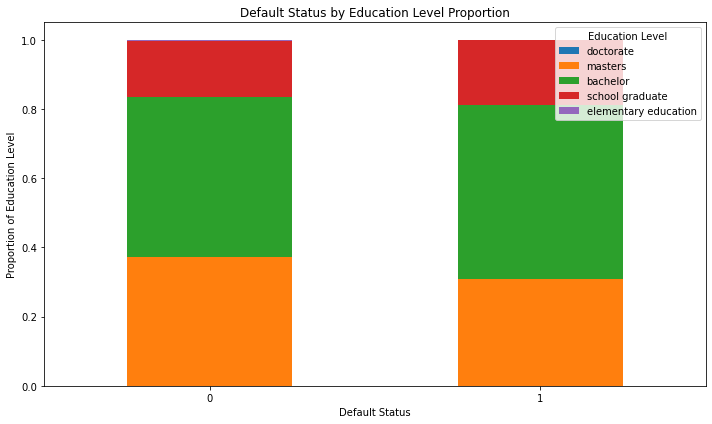

In [99]:
ed_per = ct.div(ct.sum(axis=0), axis=1)

ax = ed_per.transpose().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Status by Education Level Proportion')
plt.xlabel('Default Status')
plt.ylabel('Proportion of Education Level')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title="Education Level", loc="upper right")
plt.show()

In [47]:
def permutation_stat_cat_ind(sample1, sample2):
    ct = pd.crosstab(sample1, sample2)
    return stats.chi2_contingency(ct)[0]

def get_random_permutations(n, max_permutations):
    index = np.array(range(n))
    indices = set([tuple(index)])        
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return list(indices)

def permutation_null_dist_cat_ind(sample1, sample2, max_permutations = None):
    if not len(sample1) == len(sample2):
        raise ValueError("Samples should be paired and have the same size")
        
    n = len(sample1)
    
    if max_permutations:
        indices = get_random_permutations(n, max_permutations)
    else:
        indices = list(itertools.permutations(list(range(n))))
    
    distr = [permutation_stat_cat_ind(sample1, sample2[list(i)]) for i in indices]
    return distr

def permutation_test_cat_ind(sample1, sample2, max_permutations = None, return_distr = False):    
    t_stat = permutation_stat_cat_ind(sample1, sample2)
    
    null_distr = permutation_null_dist_cat_ind(sample1, sample2, max_permutations)
    
    p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [61]:
df_filtered = df[(df['EDUCATION'] != 6) & (df['EDUCATION'] != 5)]

sample1 = df_filtered['default'].values
sample2 = df_filtered['EDUCATION'].values

res = permutation_test_cat_ind(sample1, sample2, max_permutations=10000, return_distr=True)

In [62]:
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 120.914337, p = 0.000100


In [63]:
ct = pd.crosstab(df_filtered['EDUCATION'], df_filtered['default'])

In [64]:
def st_pearson_residuals(ct):
    e = stats.chi2_contingency(ct)[3]
    r = np.zeros(e.shape)  
    n_plus_j = ct.sum(axis=0)
    n_i_plus = ct.sum(axis=1)
    n = ct.sum().sum()
    
    for i in range(e.shape[0]):
        for j in range(e.shape[1]):
            r[i,j] = (ct.values[i,j] - e[i,j]) / np.sqrt(e[i,j] * (1 - n_i_plus.iloc[i] / n) * (1 - n_plus_j.iloc[j] / n))
            
    return pd.DataFrame(data=r, index=ct.index, columns=ct.columns)


In [66]:
st_pearson_residuals(ct)

default,0,1
EDUCATION,,
0,2.003766,-2.003766
1,9.385189,-9.385189
2,-5.707314,5.707314
3,-5.310557,5.310557
4,4.430298,-4.430298


Based on the Permutations test of independence, education level and default status are not independent $(p = 0.0001)$. Specifically:

Customers with a Master's degree and сustomers with elementary education tend to default less often than expected.
Customers with a Bachelor's degree and school graduates tend to default more frequently than expected.

### Question 4: Marital status
I used Chi-squred test for independence and Standartized Pearson's Residuals. I removed 'no data' and 'no answer' rows from the analysis

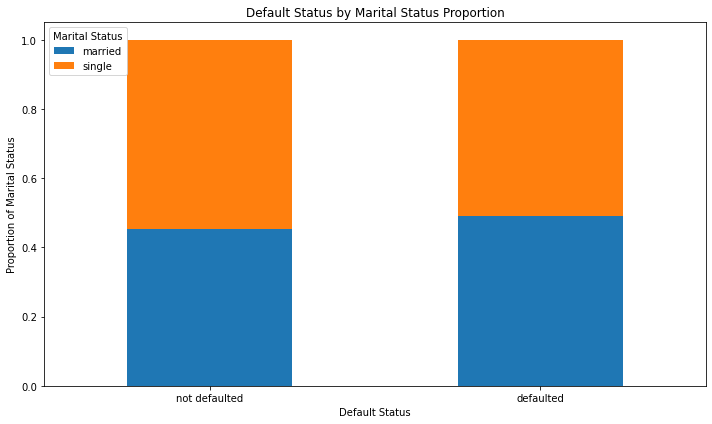

In [128]:
df_filtered = df[df['MARITAL'].isin([1, 2])]

ct = pd.crosstab(df_filtered['default'], df_filtered['MARITAL'])
ct = ct.rename(index={0: 'not defaulted', 1: 'defaulted'}, columns={1: 'married', 2: 'single'})

ct_ = ct.div(ct.sum(axis=1), axis=0)

ax = ct_.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Status by Marital Status Proportion')
plt.xlabel('Default Status')
plt.ylabel('Proportion of Marital Status')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.legend(title="Marital Status", loc="upper left")
plt.show()

In [129]:
ct

MARITAL,married,single
default,,
not defaulted,10453,12623
defaulted,3206,3341


In [130]:
stats.chi2_contingency(ct)

(27.5094090929579,
 1.5633210355976673e-07,
 1,
 array([[10640.21483307, 12435.78516693],
        [ 3018.78516693,  3528.21483307]]))

In [121]:
st_pearson_residuals(ct)

MARITAL,married,single
default,,
not defaulted,-5.258987,5.258987
defaulted,5.258987,-5.258987


Based on the Chi-squred test of independence, marital status and default status are not independent $ (p = 1.56 * 10^{-7}) $
Married individuals are more likely to default than what would be expected if marital status had no effect on defaulting. Single individuals are less likely to default than what would be expected if marital status had no effect on defaulting

### Question 5: whether there are differences between mean ages of clients in two groups

In [13]:
default = df[df['default'] == 1]['AGE']
no_default = df[df['default'] == 0]['AGE']

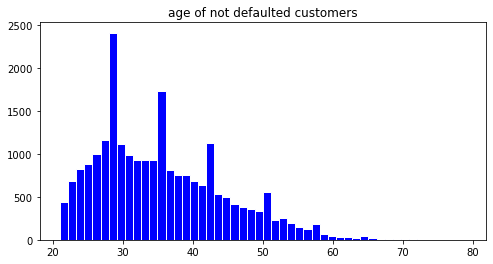

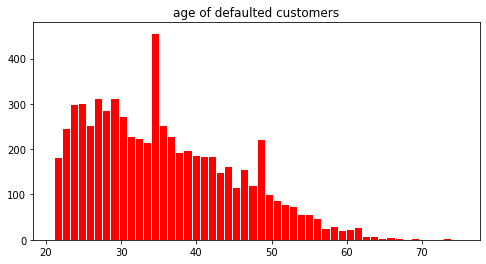

In [124]:
plt.figure(figsize = (8, 4))
ax = plt.gca()
plt.hist(no_default, bins = 50, label = 'no default', color = 'blue', edgecolor = 'white')
plt.title('age of not defaulted customers')
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()

plt.figure(figsize = (8, 4))
plt.hist(default, bins = 50, label = 'default', color = 'red', edgecolor = 'white')
plt.title('age of defaulted customers')
plt.show()

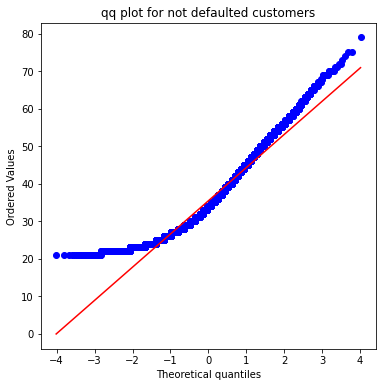

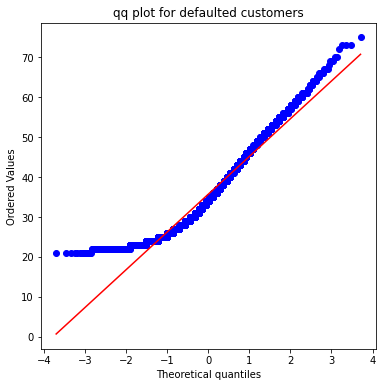

In [123]:
plt.figure(figsize = (6, 6))
stats.probplot(no_default, dist = "norm", plot = plt)
plt.title('qq plot for not defaulted customers')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(default, dist = 'norm', plot = plt)
plt.title('qq plot for defaulted customers')
plt.show()

Both samples aren't normally distributed. However, since we have enough observations in each sample, it's possible to use t-test

In [16]:
t, p = ttest_ind(default, no_default)
t, p

(2.40594177499625, 0.01613684589016384)

In [136]:
joint_dist = bp.MultiSampleEmpiricalDistribution((no_default, default))

def mean_diff(two_sample_tuple):
    return np.mean(two_sample_tuple[1]) - np.mean(two_sample_tuple[0])

print("95% confidence interval for the difference between mean age for not defaulted and defaulted customers:", 
      bp.bcanon_interval(joint_dist, mean_diff, (no_default, default), B=5000))

95% confidence interval for the difference between mean age for not defaulted and defaulted customers: (0.08932251685952508, 0.5362769664958051)


There is no atatistically significant difference between mean ages of defaulted and not defaulted clients. Difference between means with 95% confidence lies in interval [0.0893, 0.5363]